In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pylab as plt

In [183]:
from glob import glob
import json, sys, os, librosa, random, math, time, torch
sys.path.append('/home/catskills/Desktop/openasr20/end2end_asr_pytorch')
os.environ['IN_JUPYTER']='True'
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from itertools import groupby
from operator import itemgetter
import soundfile as sf
from utils import constant
from utils.functions import load_model
from utils.data_loader import SpectrogramDataset, AudioDataLoader, BucketingSampler
from clip_ends import clip_ends
import torch.optim as optim
import torchtext
from torchtext.data import Field, BucketIterator
from torchtext.data import TabularDataset
import matplotlib.ticker as ticker
from IPython.display import Audio
from unidecode import unidecode
from seq_to_seq import *

In [4]:
from config import C
C.language='amharic'
C.extension='_gradscaler'
C.batch_size=12
C.save_every = 5
C.start_from = 246
C.update()

In [5]:
files=glob(f'{C.nr_dir}/*')
n_samples=len(files)
samples=list(sorted([(librosa.load(audio_file, sr=C.sample_rate)[0].shape[0], audio_file) for audio_file in files]))

In [161]:
samples[0]

(897,
 'NIST/openasr20_amharic/build/audio_split_8000/BABEL_OP3_307_25767_20140403_234644_inLine_055_423.635_424.045.wav')

In [162]:
long_samples=samples[4842:]

In [163]:
long_sample=long_samples[0][1]
long_sample

'NIST/openasr20_amharic/build/audio_split_8000/BABEL_OP3_307_86472_20140609_222936_inLine_103_570.285_572.775.wav'

In [164]:
tgt_fn=f"{long_sample[0:-4].replace('/audio_split_8000','/transcription_split')}.txt"
tgt_fn

'NIST/openasr20_amharic/build/transcription_split/BABEL_OP3_307_86472_20140609_222936_inLine_103_570.285_572.775.txt'

In [165]:
gold_tgt=open(tgt_fn).read()
gold_tgt

'ያንን የምወድ  የምወደውን ይዘሽ እንድትመጪ'

In [166]:
sound=librosa.load(long_sample, sr=C.sample_rate)[0]

In [228]:
def split_on_longest_silence(sound, sample_rate, _cutoff = 0.0014, debug=None):
    N=100
    min_gap=0.04*sample_rate
    audio_moving=np.convolve(sound**2, np.ones((N,))/N, mode='same') 
    if debug:
        print(f'average energy over {N} sample window')
        plt.figure(figsize=(40,4))
        plt.plot(sound)
        plt.plot(audio_moving);
        plt.title(unidecode(debug))
        plt.show()
    if 0:
        threshold=0.3
        amplitudes=np.sort(audio_moving)
        n_amp=audio_moving.shape[0]
        cutoff=amplitudes[int(n_amp*threshold)]
    else:
        cutoff = _cutoff
    if debug:
        print('cutoff', cutoff)
    silence_mask=audio_moving < cutoff
    groups = [[i for i, _ in group] for key, group in groupby(enumerate(silence_mask), key=itemgetter(1)) if key]
    boundaries=[(x[0],x[-1]) for x in groups]
    silences=[(x,(y-N)) for x,y in boundaries if y-x > min_gap]
    if not silences:
        print('no silence')
        display(Audio(sound, rate=C.sample_rate))
        return (sound, None)
    if debug:
        print('#silences', len(silences))
        plt.figure(figsize=(50,8))
        plt.plot(sound);
        plt.xlabel('seconds')
        plt.ylabel('amplitude');
        for (x1,x2) in silences:
            plt.plot([x1,x2],[0,0],linewidth=5,color='red')
        plt.title('sound and detected silence')
        plt.show()
    longest_silence=list(sorted([(y-x, (x,y)) for x,y in silences]))[-1][1]
    midpoint_of_longest_silence=longest_silence[0]+((longest_silence[1]-longest_silence[0])//2)
    speech=[(0,midpoint_of_longest_silence), (midpoint_of_longest_silence,sound.shape[0])]
    sounds=[clip_ends(sound[a:b], 0.0008) for a,b in speech]
    if debug:
        spliced=np.hstack(sounds)
        plt.figure(figsize=(50,8))
        plt.plot(spliced);
        plt.xlabel('seconds')
        plt.ylabel('amplitude');
        plt.title('spliced')
        print(f'sound: {unidecode(debug)}')
        display(Audio(sound, rate=C.sample_rate))
        print('spliced')
        display(Audio(spliced, rate=C.sample_rate))
        for i, sound in enumerate(sounds):
            print('segment', i)
            display(Audio(sound, rate=C.sample_rate))
            plt.figure(figsize=(50,8))
            plt.plot(sound);
            plt.xlabel('seconds')
            plt.ylabel('amplitude');
            plt.title(f"segment {i}")
        plt.show()
    return sounds

average energy over 100 sample window


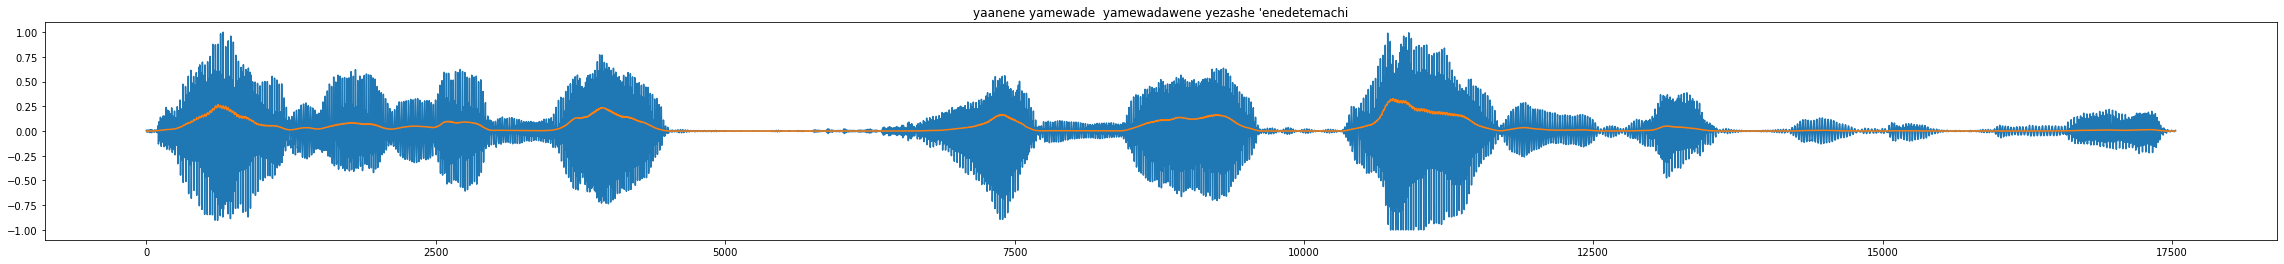

cutoff 0.001
#silences 4


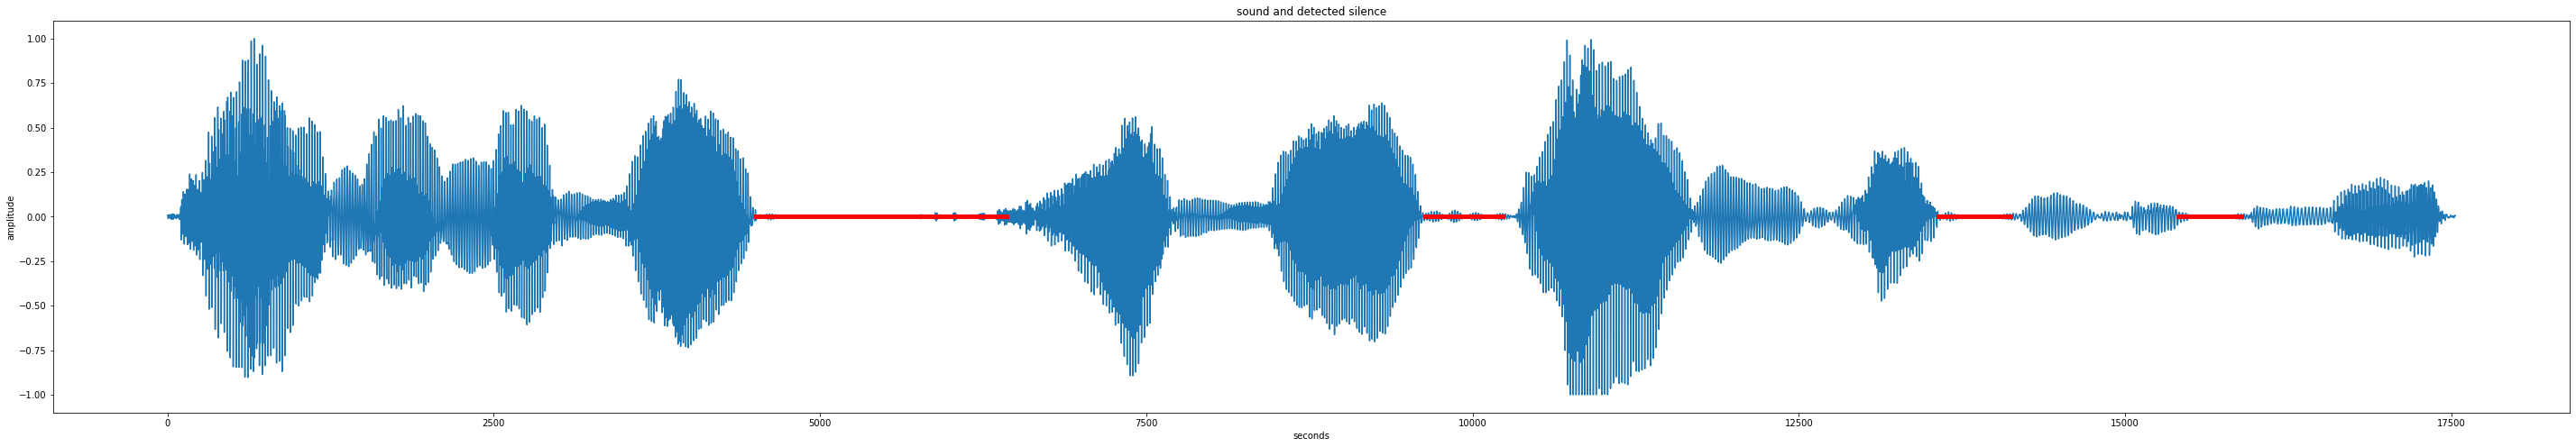

sound: yaanene yamewade  yamewadawene yezashe 'enedetemachi


spliced


segment 0


segment 1


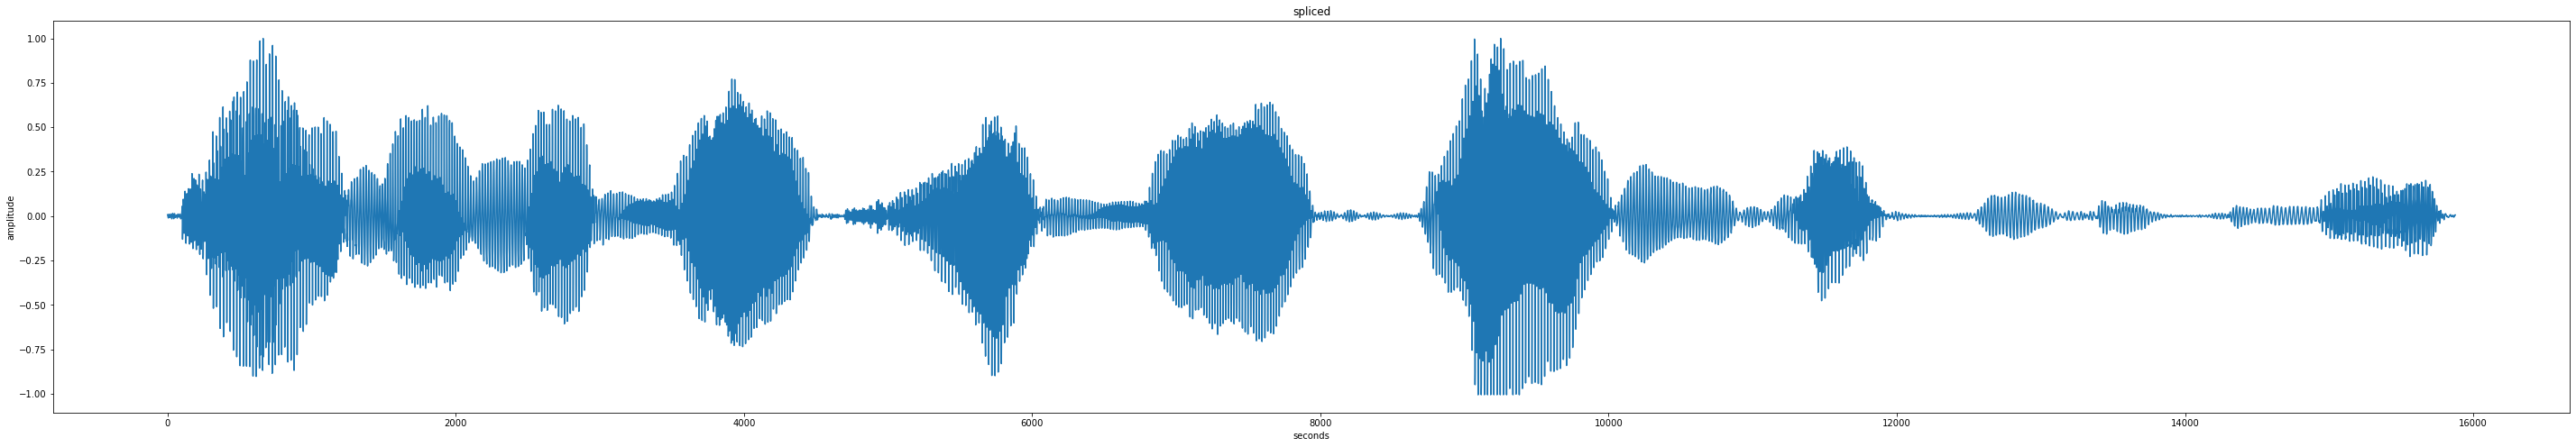

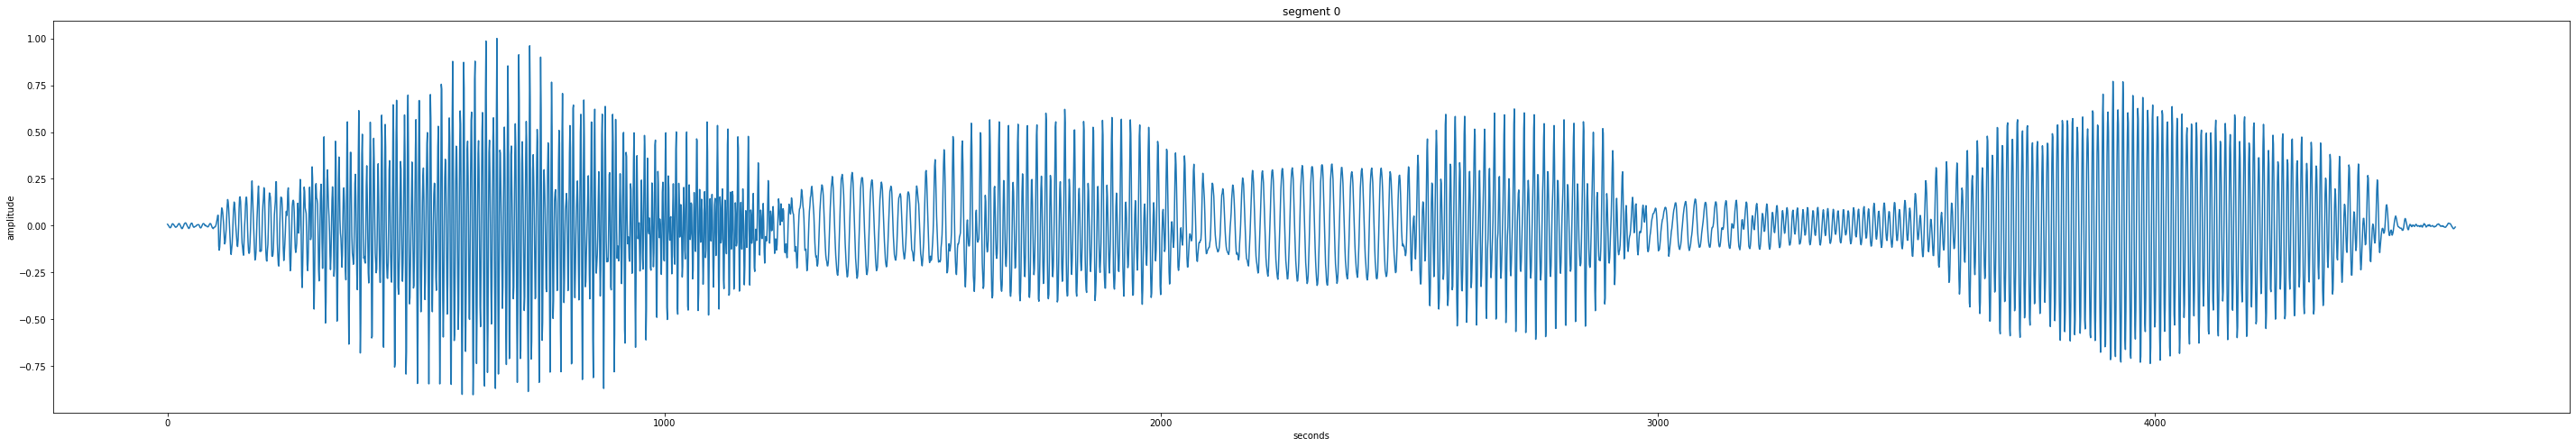

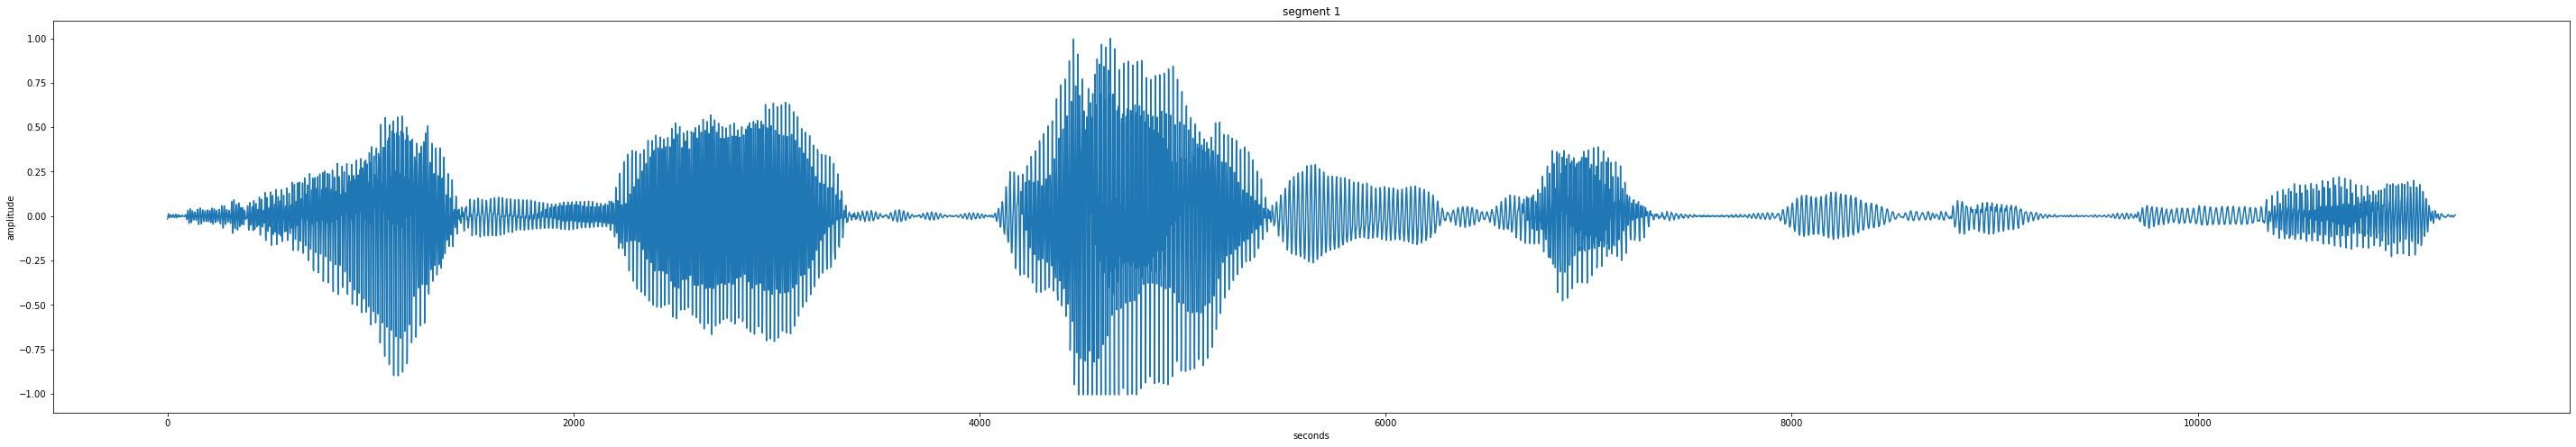

In [221]:
s1,s2=split_on_longest_silence(sound, C.sample_rate, 0.001, gold_tgt)

average energy over 100 sample window


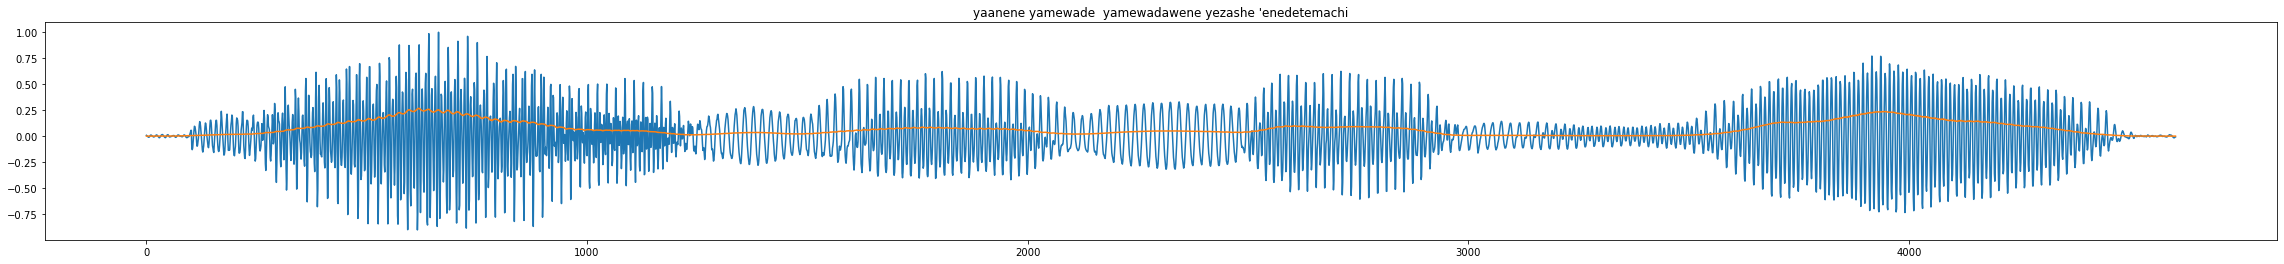

cutoff 0.001
no silence


In [229]:
s1a,s1b=split_on_longest_silence(s1, C.sample_rate, 0.001, gold_tgt)

average energy over 100 sample window


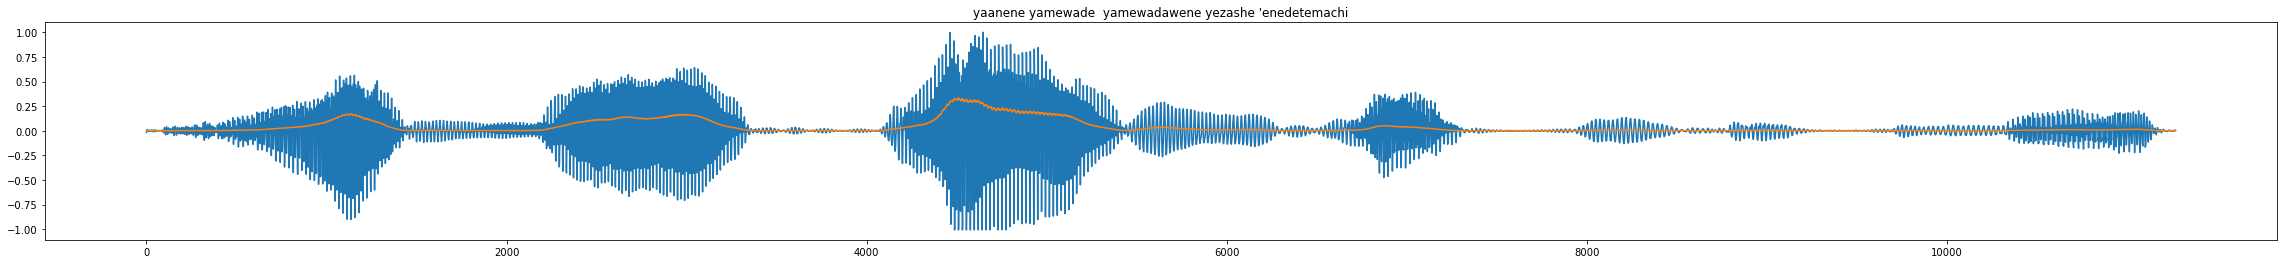

cutoff 0.001
#silences 3


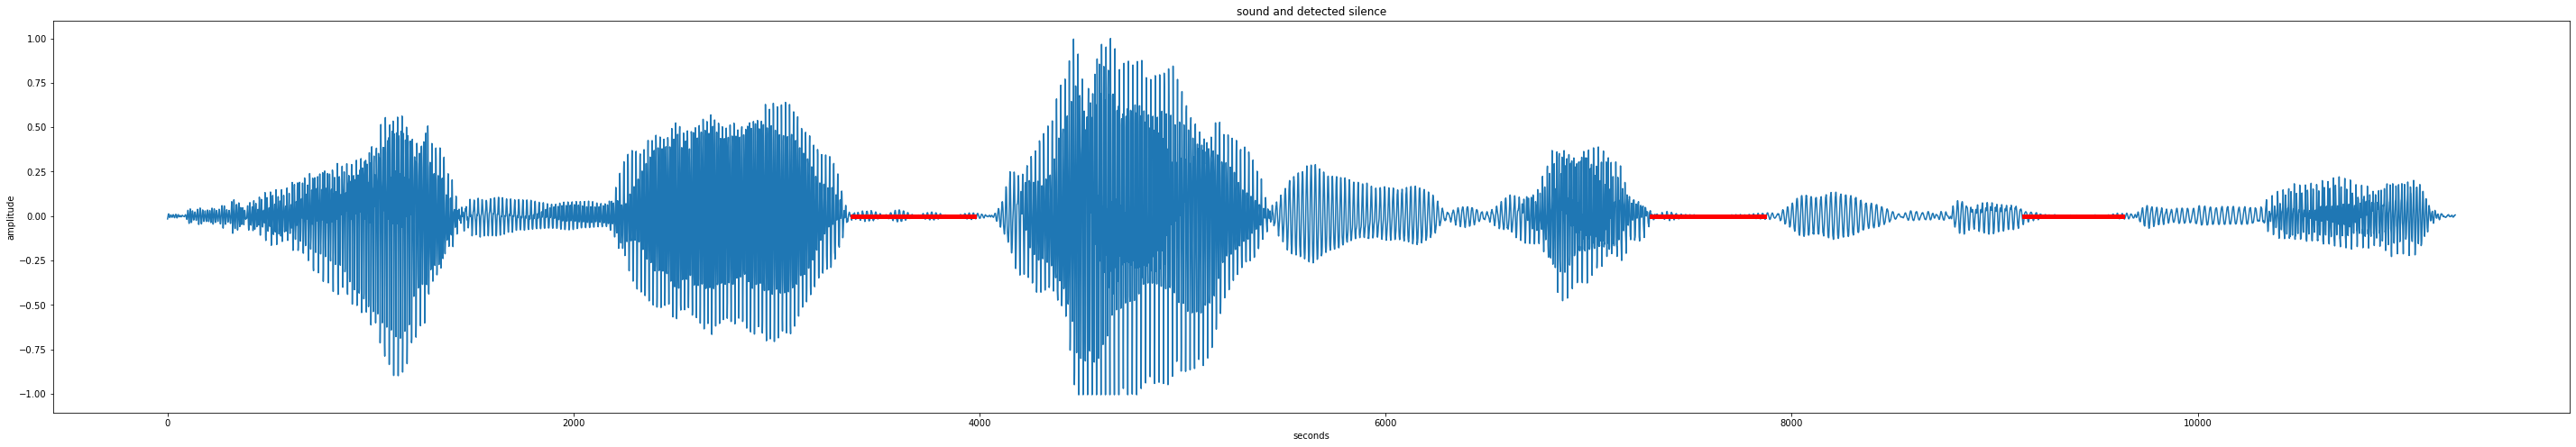

sound: yaanene yamewade  yamewadawene yezashe 'enedetemachi


spliced


segment 0


segment 1


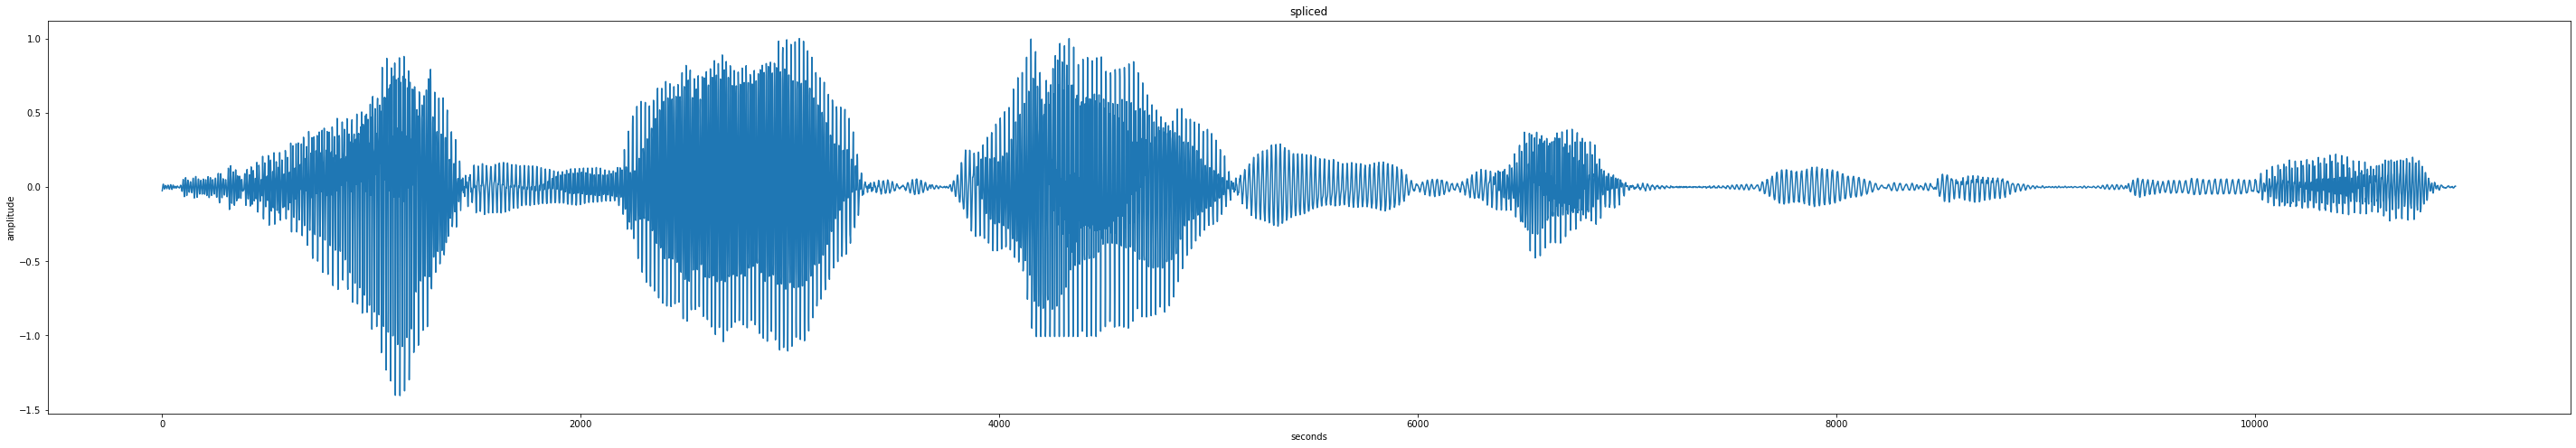

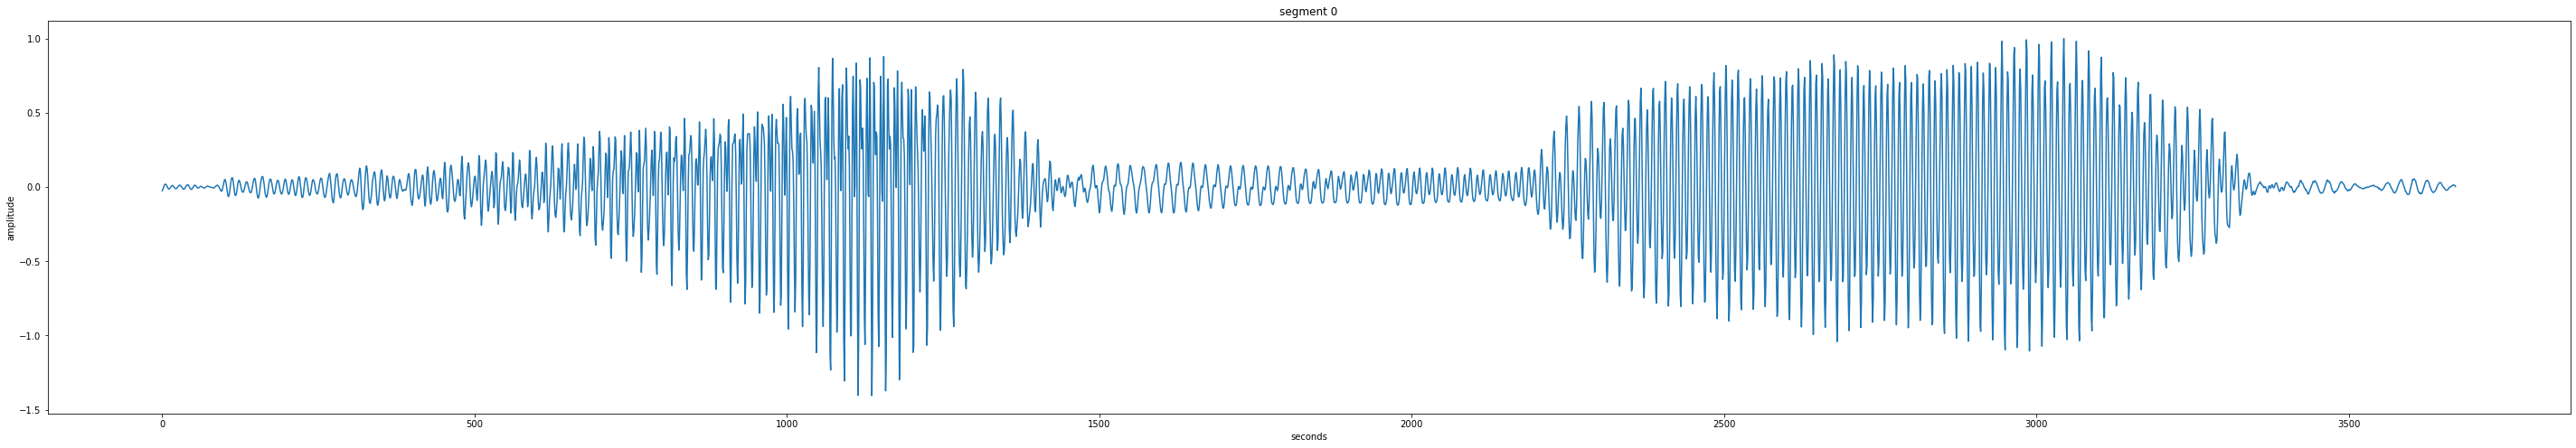

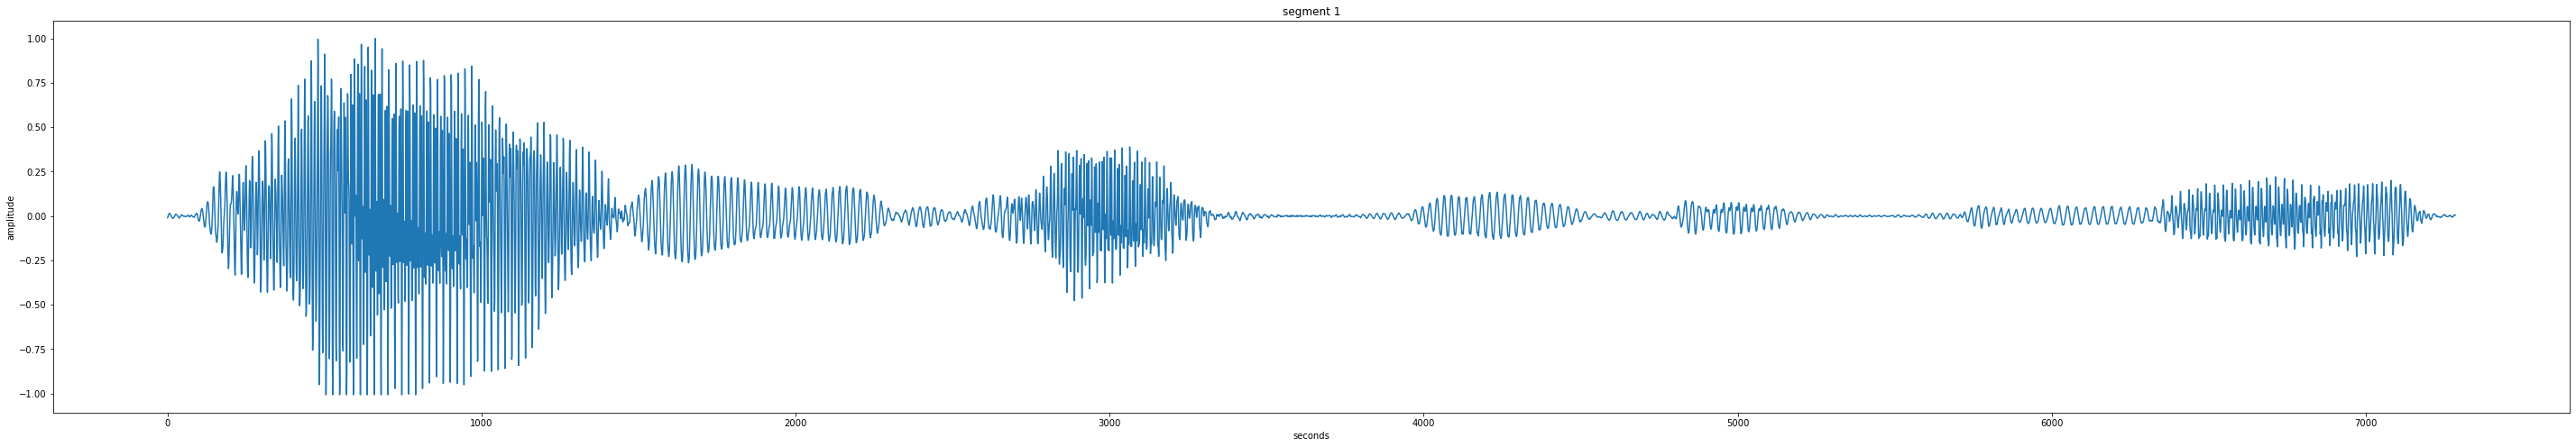

In [230]:
s2a,s2b=split_on_longest_silence(s2, C.sample_rate, 0.001, gold_tgt)

average energy over 100 sample window


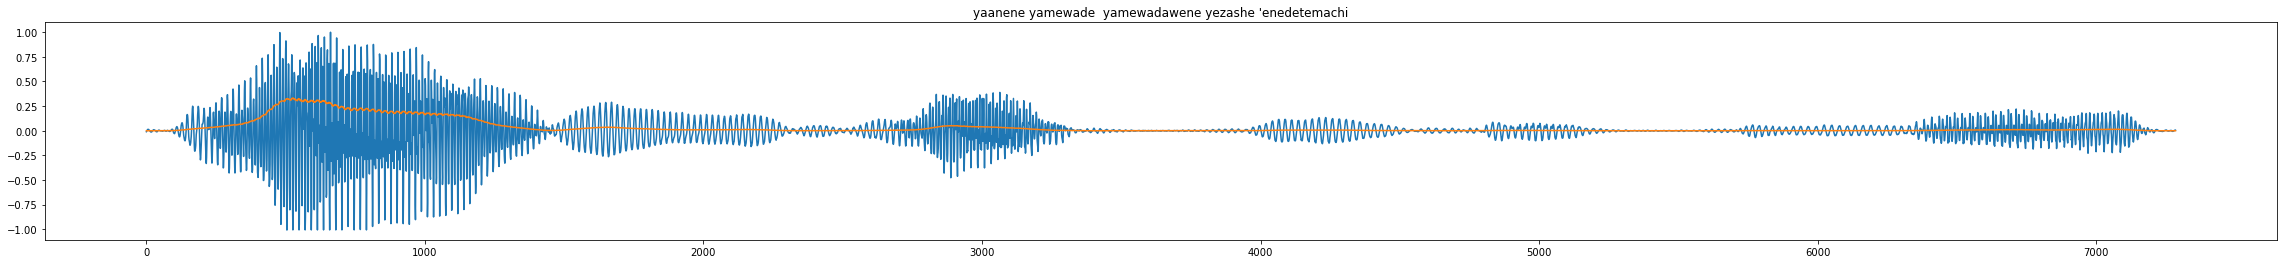

cutoff 0.001117026759027926
#silences 2


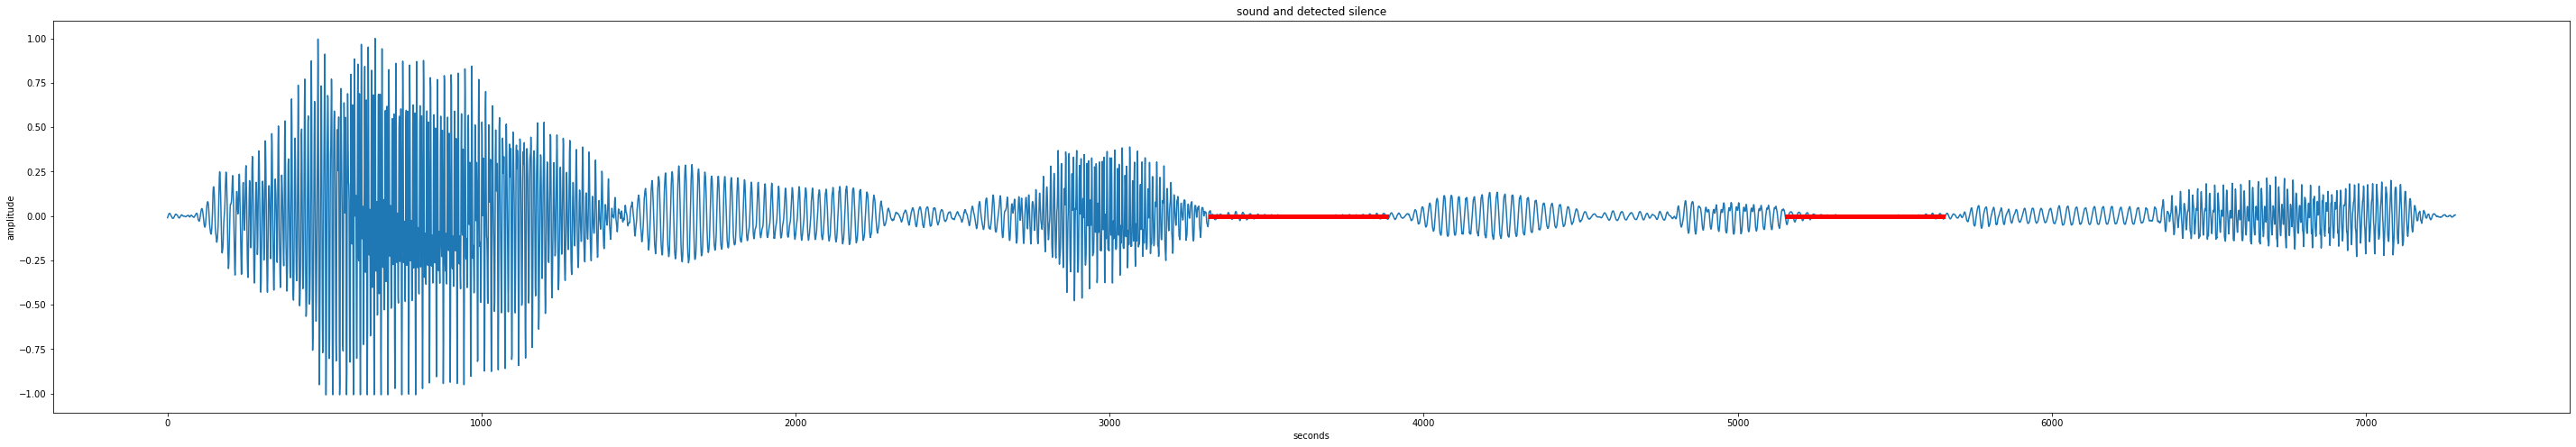

sound: yaanene yamewade  yamewadawene yezashe 'enedetemachi


spliced


segment 0


segment 1


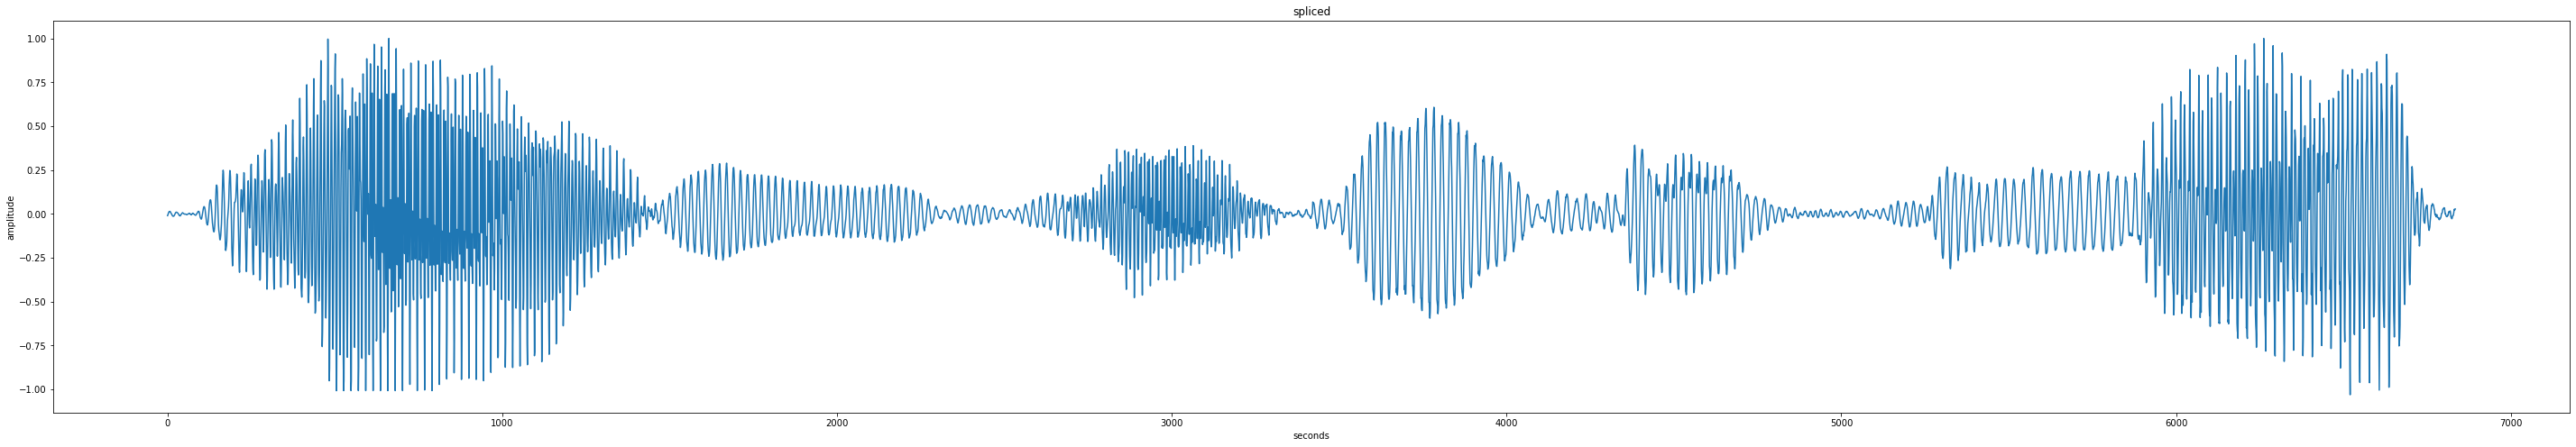

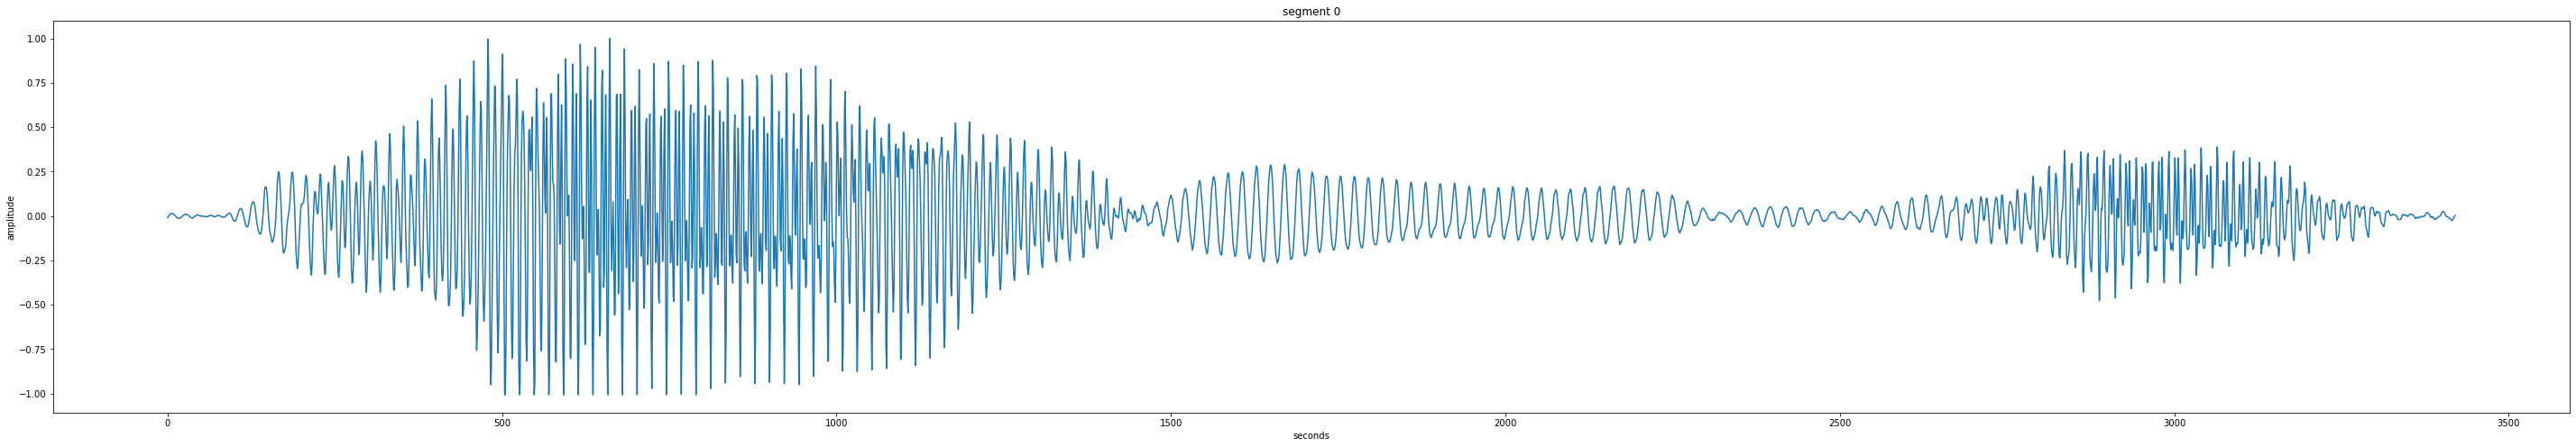

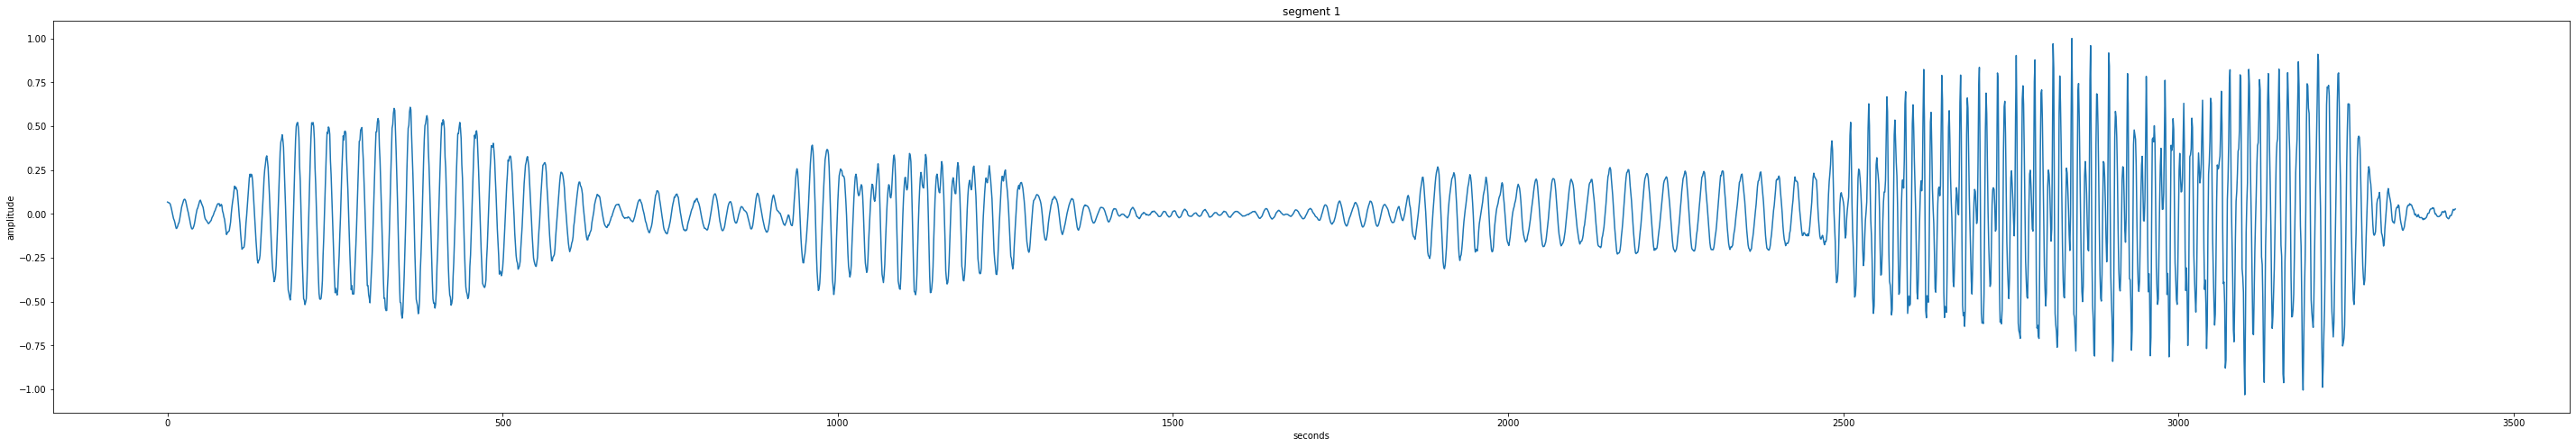

In [206]:
s2b1,s2b2=split_on_longest_silence(s2b, C.sample_rate,  0.001, gold_tgt)

average energy over 100 sample window


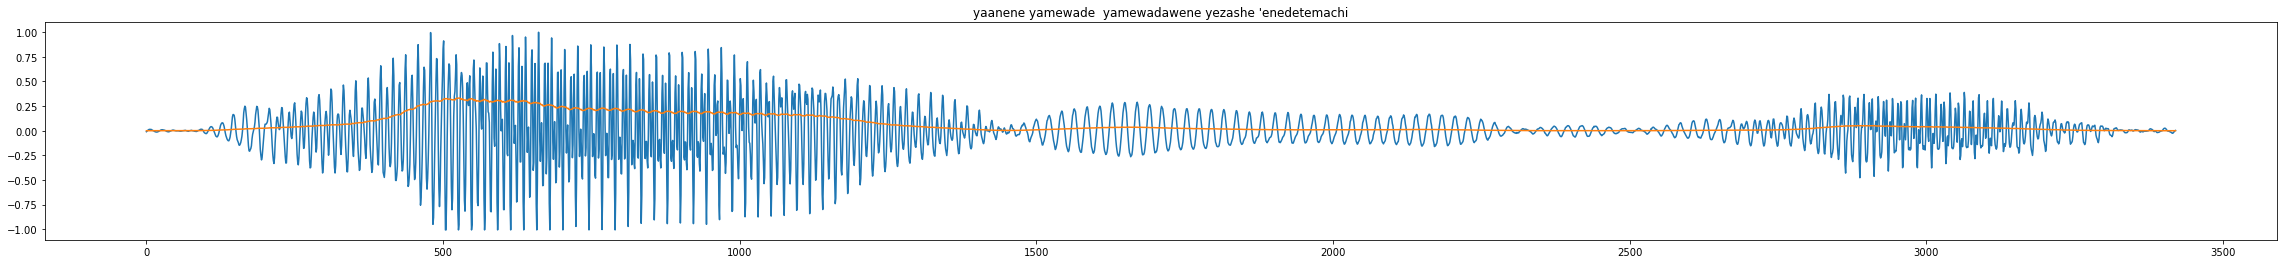

cutoff 0.001
no silence


In [231]:
s2b1a,s2b1b=split_on_longest_silence(s2b1, C.sample_rate,  0.001, gold_tgt)

average energy over 100 sample window


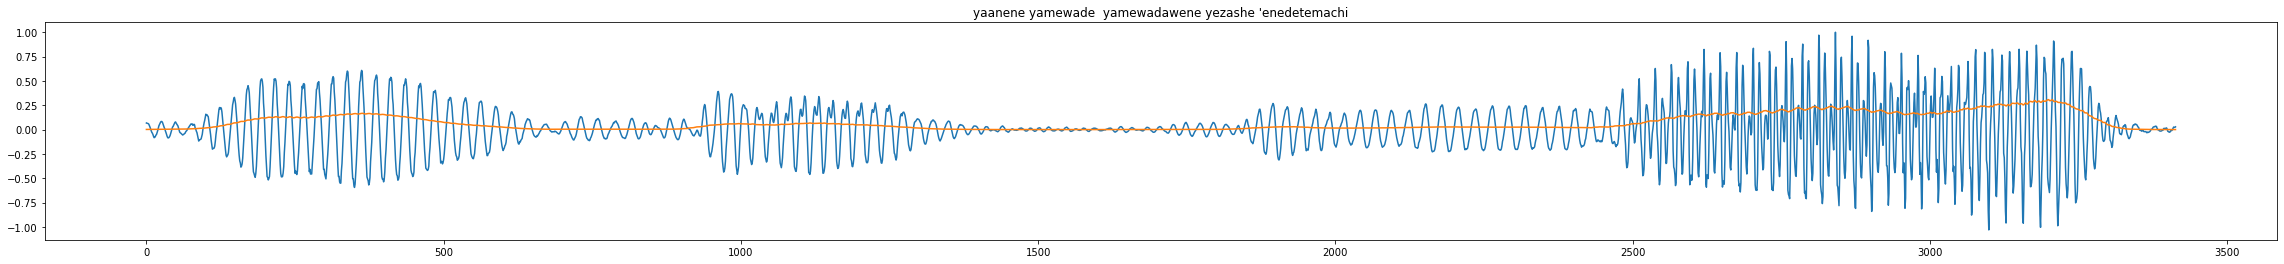

cutoff 0.001
no silence


In [232]:
s2b2a,s2b2b=split_on_longest_silence(s2b2, C.sample_rate,  0.001, gold_tgt)

In [234]:
unidecode(gold_tgt)

"yaanene yamewade  yamewadawene yezashe 'enedetemachi"

In [33]:
!mkdir -p frob
!rm frob/*

In [34]:
clips=[]
for i, sound in enumerate(sounds):
    fn=f"frob/clip_{i}.wav"
    sf.write(fn, sound, C.sample_rate)
    clips.append(fn)

In [35]:
text='infer.txt'
manifest_fn='manifest.csv'
manifest='\n'.join([f'{audio},{text}' for audio in clips])
with open(manifest_fn, 'w') as f:        plt.show()
    f.write(manifest)

In [36]:
!cat manifest.csv

frob/clip_0.wav,infer.txt
frob/clip_1.wav,infer.txt

In [37]:
args=constant.args
args.continue_from=None
args.cuda = True
args.labels_path = C.grapheme_dictionary_fn
args.lr = 1e-4
args.name = C.model_name
args.save_folder = f'save'
args.epochs = 1000
args.save_every = 1
args.feat_extractor = f'vgg_cnn'
args.dropout = 0.1
args.num_layers = 4
args.num_heads = 8
args.dim_model = 512
args.dim_key = 64
args.dim_value = 64
args.dim_input = 161
args.dim_inner = 2048
args.dim_emb = 512
args.shuffle=True
args.min_lr = 1e-6
args.k_lr = 1
args.sample_rate=C.sample_rate
args.continue_from=C.best_model
args.augment=True
audio_conf = dict(sample_rate=args.sample_rate,
                  window_size=args.window_size,
                  window_stride=args.window_stride,
                  window=args.window,
                  noise_dir=args.noise_dir,
                  noise_prob=args.noise_prob,
                  noise_levels=(args.noise_min, args.noise_max))

In [38]:
with open(args.labels_path, 'r') as label_file:
    labels = str(''.join(json.load(label_file)))
# add PAD_CHAR, SOS_CHAR, EOS_CHAR
labels = constant.PAD_CHAR + constant.SOS_CHAR + constant.EOS_CHAR + labels
label2id, id2label = {}, {}
count = 0
for i in range(len(labels)):
    if labels[i] not in label2id:
        label2id[labels[i]] = count
        id2label[count] = labels[i]
        count += 1
    else:
        print("multiple label: ", labels[i])

model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(constant.args.continue_from)

In [39]:
train_data = SpectrogramDataset(audio_conf, manifest_filepath_list=[manifest_fn], 
                                label2id=label2id, normalize=True, augment=args.augment)
args.batch_size=1
train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
train_loader = AudioDataLoader(train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

strs_hyps=[]
for i, (data) in enumerate(tqdm(train_loader)):
    src, tgt, _, src_lengths, tgt_lengths = data
    src = src.cuda()
    tgt = tgt.cuda()
    pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)
    seq_length = pred.size(1)
    for ut_hyp in hyp_seq:
        str_hyp = ""
        for x in ut_hyp:
            if int(x) == constant.PAD_TOKEN:
                break
            str_hyp = str_hyp + id2label[int(x)]
        strs_hyps.append(str_hyp)
for j in range(len(strs_hyps)):
    strs_hyps[j] = strs_hyps[j].replace(constant.SOS_CHAR, '').replace(constant.EOS_CHAR, '')

In [40]:
gold_tgt = ' '.join([x.strip() for x in gold_tgt.split(' ') if x])
gold_tgt

'ያንን የምወድ የምወደውን ይዘሽ እንድትመጪ'

In [41]:
pred=' '.join(strs_hyps)
pred

'lኙ ይጽ'

In [92]:
error_correction_training_fn='frob/pred_gold.tsv'
with open(error_correction_training_fn, 'w', encoding='utf-8') as f:
    f.write(f"{gold_tgt}\t{pred}")

In [93]:
!cat frob/pred_gold.tsv

ያንን የምወድ የምወደውን ይዘሽ እንድትመጪ	lኙ ይጽ

In [94]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
tokenize=lambda x: [y for y in x]

SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [95]:
from torchtext.data import Iterator

In [96]:
train_data = TabularDataset(
    path=error_correction_training_fn,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)])

In [97]:
train_iterator = Iterator(train_data, batch_size=1)

In [98]:
gold_fns=list(sorted(glob(f'{C.build_dir}/transcription_split/*.txt')))
len(gold_fns)
import os
goldrows=[]
for fn in gold_fns:
    with open(fn, 'r', encoding='utf-8') as f:
        goldrows.append(f.read())

MAX_LENGTH=max(len(x) for x in goldrows)+10
MAX_LENGTH

graphemes=''.join([x for x in C.grapheme_dictionary])

MIN_FREQ=1

In [99]:
SRC.build_vocab(graphemes, min_freq = MIN_FREQ)

In [100]:
TRG.build_vocab(graphemes, min_freq = MIN_FREQ)
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
INPUT_DIM, OUTPUT_DIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [101]:
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              MAX_LENGTH)

In [102]:
dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LENGTH)

In [103]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

In [104]:
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [105]:
model_fn='tut6-model.pt'

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,275,695 trainable parameters


In [106]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

if os.path.exists(model_fn):
    model.load_state_dict(torch.load(model_fn))

LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [107]:
model.train()

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(239, 256)
    (pos_embedding): Embedding(270, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      

In [108]:
for j in range(100):
    epoch_loss = 0
    for i, batch in enumerate(train_iterator):

        src = batch.src.to(device)
        trg = batch.trg.to(device)

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        epoch_loss += loss.item()
        
    print(j, epoch_loss)

0 5.745236873626709
1 3.9713361263275146
2 3.857621908187866
3 3.4305737018585205
4 3.2412614822387695
5 2.909562349319458
6 3.045175075531006
7 2.784417152404785
8 2.689488649368286
9 2.273806571960449
10 2.151329517364502
11 1.7985273599624634
12 1.7029579877853394
13 1.4830800294876099
14 1.1524525880813599
15 0.9927318096160889
16 0.9238938689231873
17 0.8169228434562683
18 0.6006374359130859
19 0.46186721324920654
20 0.48034656047821045
21 0.4239625632762909
22 0.5358075499534607
23 0.3562217652797699
24 0.35904502868652344
25 0.5303807258605957
26 0.3374912738800049
27 0.2531319558620453
28 0.30249589681625366
29 0.14183355867862701
30 0.2184533029794693
31 0.23198848962783813
32 0.13827066123485565
33 0.09722942113876343
34 0.26952463388442993
35 0.31092509627342224
36 0.1595088690519333
37 0.10340991616249084
38 0.14741188287734985
39 0.12247728556394577
40 0.1287849098443985
41 0.05472823604941368
42 0.0816105529665947
43 0.08226633816957474
44 0.06353038549423218
45 0.0632221

In [122]:
pred=output.argmax(1).cpu().detach().numpy()
pred

array([162, 105, 105,   4, 159,  30, 134, 171,   4, 159,  30, 134, 166,
       139, 105,   4, 164, 145,  59,   4, 119, 105, 171,  88,  25, 200,
         3])

In [109]:
''.join([SRC.vocab.itos[x] for x in src.cpu().numpy()[0]])

'<sos><unk>ኙ ይጽ<eos>'

In [127]:
silver=''.join([TRG.vocab.itos[x] for x in trg.cpu().numpy()]).split('<eos>')[0]
silver

'ያንን የምወድ የምወደውን ይዘሽ እንድትመጪ'

In [128]:
pred=''.join([TRG.vocab.itos[x] for x in pred]).split('<eos>')[0]
pred

'ያንን የምወድ የምወደውን ይዘሽ እንድትመጪ'

In [131]:
from utils.metrics import calculate_cer, calculate_wer

In [132]:
calculate_cer(pred, silver)

0

In [133]:
calculate_wer(pred, silver)

0